# Preamble

In [ ]:
import $ivy.`org.http4s::http4s-ember-client:0.23.23`
import $ivy.`org.http4s::http4s-dsl:0.23.23`
import $ivy.`org.http4s::http4s-circe:1.0.0-M40`
import $ivy.`co.fs2::fs2-core:3.8.0`
import $ivy.`co.fs2::fs2-io:3.8.0`
import $ivy.`io.circe::circe-parser:0.15.0-M1`
import $ivy.`io.circe::circe-generic:0.15.0-M1`
import $ivy.`org.slf4j:slf4j-nop:2.0.9`
import $ivy.`io.circe::circe-optics:0.15.0`
import $ivy.`dev.optics::monocle-macro:3.2.0`
import $ivy.`org.scalatest::scalatest:3.2.16`

In [ ]:
import $file.templates.preamble, preamble._

In [ ]:
import fs2.{Pipe, Pull, Stream}
import fs2.io.net.Network
import cats.effect.{IO, Async}
import cats.effect.unsafe.IORuntime
import cats.effect.unsafe.implicits.global
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._
import org.typelevel.log4cats.LoggerFactory
import org.typelevel.log4cats.slf4j.Slf4jFactory
given LoggerFactory[IO] = Slf4jFactory.create[IO]
import org.scalatest.{Filter => _, run => runTest, _}, flatspec._, matchers._

# $2^{nd}$ step: domain abstraction

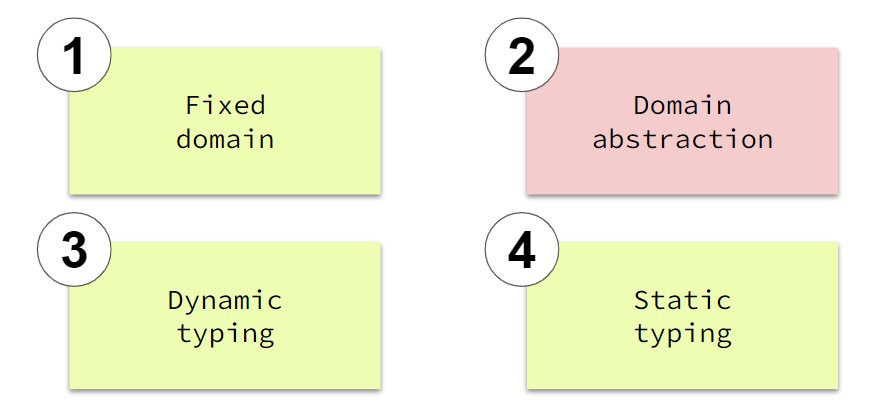

### Goals

* Learn how to abstract over specific semantics using type classes, and understand the advantages and disadvantages of this approach.
* Understand the importance of the *standard semantics* of the language.
* Gain the ability to implement generic programs using both ad-hoc polymorphic methods and functions.


# Type class-based representation

Let’s move to the next step and implement a new version of the embedding. Essentially, we’ll abstract away the specific semantic domain our implementation is based on, whether it’s fs2 pipes, Akka Streams, or another framework. The result of this abstraction will be a type class, where the deep syntax operators remain abstract. The built-in library and syntactic sugar, typically implemented in a separate object, can then be freely reused across different implementations.


In [ ]:
trait Jq[Filter] extends StdLib[Filter]:

    def id: Filter
    def iterator: Filter
    def array(f: Filter): Filter

    extension (s: String)
        def str: Filter
    
    extension (f1: Filter)
        def |(f2: => Filter): Filter
        def index(f2: => Filter): Filter
        def ++(f2: => Filter): Filter

object Jq:

    object Syntax: 

        def arr[Filter](filters: Filter*)(using J: Jq[Filter]): Filter =
            J.array(filters.reduce(J.++(_)(_)))

        extension [Filter](sc: StringContext)(using J: Jq[Filter])
            def i(args: Filter*): Filter = 
                sc.s().split('.').toList
                    .map(key => J.id.index(J.str(key)))
                    .reduce(J.|(_)(_))

        // Boilerplate

        def id[Filter](using J: Jq[Filter]): Filter = J.id
        def iterator[Filter](using J: Jq[Filter]): Filter = J.iterator 

trait StdLib[Filter]: 
    self: Jq[Filter] =>
    
    def map(f: Filter): Filter = 
        array(iterator | f)
    

In [ ]:
import Jq.Syntax._

<img src="images/scala3book.jpg" width="200px" style="width: 200px;padding-right:0px;padding-top:-50px;padding-left:5px;" align="top"/>

<p style='color:#273a6e'><i>Check out the section on <a href=https://docs.scala-lang.org/scala3/book/ca-type-classes.html>Type Classes</a> from the Scala 3 book</i></p>

#### Fs2 semantics

Particular semantics are implemented in terms of `given` instances of this type class:

In [ ]:
object Jq_Fs2: 

    type Filter[F[_]] = Pipe[F, Json, Json]

    given [F[_]]: Jq[Filter[F]] with 
                     
        def id: Filter[F] = 
            identity[Stream[F, Json]]

        extension (s: String)
            def str: Filter[F] = 
                _.map(_ => Json.fromString(s))

        def iterator: Filter[F] = 
            _ flatMap: 
                case IsArray(v) => Stream(v*)
                case _ => Stream(Json.Null)

        extension (f1: Filter[F])

            def |(f2: => Filter[F]): Filter[F] = 
                _ flatMap: json => 
                    f1(Stream(json)).flatMap: json2 => 
                        f2(Stream(json2)) 

            def index(f2: => Filter[F]): Filter[F] = 
                   _ flatMap: v => 
                        (f1(Stream(v)) cross f2(Stream(v)))
                            .map:
                                case (IsObject(obj), IsString(key)) => 
                                    obj(key).getOrElse(Json.Null)
                                case _ => Json.Null

            def ++(f2: => Filter[F]): Filter[F] = 
                _.flatMap: json => 
                    f1(Stream(json)) ++ f2(Stream(json))

        def array(f: Filter[F]): Filter[F] = 
            _ flatMap: json => 
                f(Stream(json))
                    .fold(List[Json]())(_ :+ _)
                    .map(Json.arr)

To implement the same programs as in the ad-hoc embedding for fs2, we simply need to import the `given` instance:

In [ ]:
object ExtractInfo_Fs2:

    import Jq_Fs2.given

    def apply[F[_]]: Pipe[F, Json, Json] = 
        iterator | arr(i"author.login", i"commit.author.date")

# Standard semantics

The standard semantics of a language serves as a reference implementation, helping us understand the meaning of the various syntactic constructs. It is typically built upon the standard structures of the host language. Below is an implementation of the jq embedding for `Iterator`s, based on a fixed-domain implementation:


In [ ]:
// REFACTOR THIS IMPLEMENTATION AS NEEDED

/********************** DEEP SYNTAX ***********************/

object Jq_It: 

    type Filter = Iterator[Json] => Iterator[Json]

    def id: Filter = 
        identity[Iterator[Json]]

    def str(s: String): Filter = 
        _.map(_ => Json.fromString(s))

    def iterator: Filter = 
        _ flatMap: 
            case IsArray(v) => Iterator(v*)
            case _ => Iterator(Json.Null)

    extension (f1: Filter)

        def |(f2: => Filter): Filter = 
            _ flatMap: json => 
                f1(Iterator(json)).flatMap: json2 => 
                    f2(Iterator(json2)) 

        def index(f2: => Filter): Filter = 
            _ flatMap: v => 
                (f1(Iterator(v)) crossI f2(Iterator(v)))
                    .map:
                        case (IsObject(obj), IsString(key)) => 
                            obj(key).getOrElse(Json.Null)
                        case _ => Json.Null

        def ++(f2: => Filter): Filter = 
            _.flatMap: json => 
                f1(Iterator(json)) ++ f2(Iterator(json))

    def array(f: Filter): Filter = 
        _ map: json => 
            Json.arr(f(Iterator(json)).toSeq*)

In [ ]:
import Jq_It._

In [ ]:
object Jq_It_Sugar:

    def arr(filters: Filter*): Filter =
        array(filters.reduce(_ ++ _))

    extension (sc: StringContext)
        def i(args: Filter*): Filter = 
            sc.s().split('.').map(key => id.index(str(key))).reduce(_ | _)

In [ ]:
import Jq_It_Sugar._

In [ ]:
val ExtractInfo_It: Iterator[Json] => Iterator[Json] = 
    iterator | arr(i"author.login", i"commit.author.date")

In [ ]:
val allPages: Iterator[Json] = 
    allCommitPages[IO]("https://api.github.com/repos/hablapps/blog")
        .run
        .iterator

In [ ]:
ExtractInfo_It(allPages).take(2).toList

#### Exercise
<div class="alert alert-info">
    Implement the standard semantics based on <code>Iterator</code>'s as an instance of the Jq type class. 
</div>    



##### Solution

In [ ]:
object Jq_It: 

    type Filter = Iterator[Json] => Iterator[Json]

    given Jq[Filter] with 

        def id: Filter = 
            identity[Iterator[Json]]

        extension (s: String)
            def str: Filter = 
                _.map(_ => Json.fromString(s))

        def iterator: Filter = 
            _ flatMap: 
                case IsArray(v) => Iterator(v*)
                case _ => Iterator(Json.Null)

        extension (f1: Filter)

            def |(f2: => Filter): Filter = 
                _ flatMap: json => 
                    f1(Iterator(json)).flatMap: json2 => 
                        f2(Iterator(json2)) 

            def index(f2: => Filter): Filter = 
                _ flatMap: v => 
                    (f1(Iterator(v)) crossI f2(Iterator(v)))
                        .map:
                            case (IsObject(obj), IsString(key)) => 
                                obj(key).getOrElse(Json.Null)
                            case _ => Json.Null

            def ++(f2: => Filter): Filter = 
                _.flatMap: json => 
                    f1(Iterator(json)) ++ f2(Iterator(json))

        def array(f: Filter): Filter = 
            _ map: json => 
                Json.arr(f(Iterator(json)).toSeq*)

In [ ]:
object ExtractInfo_It: 
    import Jq_It.given

    val apply: Iterator[Json] => Iterator[Json] = 
        iterator | arr(i"author.login", i"commit.author.date")

##### Your solution

In [ ]:
// REFACTOR THIS IMPLEMENTATION AS NEEDED

/********************** DEEP SYNTAX ***********************/

object Jq_It: 

    export Jq_It_Sugar._

    type Filter = Iterator[Json] => Iterator[Json]

    def id: Filter = 
        identity[Iterator[Json]]

    extension (s: String)
        def str: Filter = 
            _.map(_ => Json.fromString(s))

    def iterator: Filter = 
        _ flatMap: 
            case IsArray(v) => Iterator(v*)
            case _ => Iterator(Json.Null)

    extension (f1: Filter)

        def |(f2: => Filter): Filter = 
            _ flatMap: json => 
                f1(Iterator(json)).flatMap: json2 => 
                    f2(Iterator(json2)) 

        def index(f2: => Filter): Filter = 
            _ flatMap: v => 
                (f1(Iterator(v)) crossI f2(Iterator(v)))
                    .map:
                        case (IsObject(obj), IsString(key)) => 
                            obj(key).getOrElse(Json.Null)
                        case _ => Json.Null

        def ++(f2: => Filter): Filter = 
            _.flatMap: json => 
                f1(Iterator(json)) ++ f2(Iterator(json))

    def array(f: Filter): Filter = 
        _ map: json => 
            Json.arr(f(Iterator(json)).toSeq*)


In [ ]:
import Jq_It._

In [ ]:
object Jq_It_Sugar:

    def arr(filters: Filter*): Filter =
        array(filters.reduce(_ ++ _))

    extension (sc: StringContext)
        def i(args: Filter*): Filter = 
            sc.s().split('.').map(key => id.index(str(key))).reduce(_ | _)

In [ ]:
// REFACTOR THIS IMPLEMENTATION AS NEEDED

object ExtractInfoIt: 
    import Jq_It._

    val apply: Iterator[Json] => Iterator[Json] = 
        iterator | arr(i"author.login", i"commit.author.date")

# Ad-hoc polymorphic programs

You may have noticed that the implementation of the `extractInfo` programs for both the standard semantics and the fs2 semantics are remarkably similar:

In [ ]:
import Jq.Syntax._

In [ ]:
object ExtractInfo_Fs2:
    import Jq_Fs2.given

    def apply[F[_]]: Pipe[F, Json, Json] = 
        iterator | arr(i"author.login", i"commit.author.date")

In [ ]:
object ExtractInfo_It: 
    import Jq_It.given

    val apply: Iterator[Json] => Iterator[Json] = 
        iterator | arr(i"author.login", i"commit.author.date")

Is it possible to provide a single, generic implementation that works across all semantic domains?

#### Ad-hoc polymorphic methods

Yes, we can! By abstracting over the semantic domain and constraining the corresponding generic parameter with a context bound for the `Jq` type class, we can achieve this. The result is an ad-hoc polymorphic method:

In [ ]:
def extractInfo[R: Jq]: R = 
    iterator | arr(i"author.login", i"commit.author.date")

<img src="images/scala3book.jpg" width="200px" style="width: 200px;padding-right:0px;padding-top:-50px;padding-left:5px;" align="top"/>

<p style='color:#273a6e'><i>Check out the section on <a href=https://docs.scala-lang.org/scala3/book/ca-context-bounds.html>Context bounds</a> from the Scala 3 book</i></p>

This generic program can now be used to retrieve the desired semantics:

In [ ]:
object ExtractInfo_Fs2:
    import Jq_Fs2.given

    def apply[F[_]]: Pipe[F, Json, Json] = 
        extractInfo[Jq_Fs2.Filter[F]]

In [ ]:
object ExtractInfo_It: 
    import Jq_It.given

    val apply: Iterator[Json] => Iterator[Json] = 
        extractInfo[Jq_It.Filter]

#### Using polymorphic & context function types

In the ADT approach, it is clear that our DSL is defined by a *type*, and instances of this type are our *programs*. In the tagless-final approach, however, programs are defined by ad-hoc polymorphic methods. Can we still define our *type of programs*? In Scala 3, this is fairly simple using polymorphic and context function types:

In [ ]:
val extractInfo: [R] => Jq[R] ?=> R = 
    [R] => (_ : Jq[R]) ?=> 
        iterator | arr(i"author.login", i"commit.author.date")

<img src="images/scala3reference.jpg" width="200px" style="width: 200px;padding-right:0px;padding-top:-50px;padding-left:5px;" align="top"/>

<p style='color:#273a6e'><i>Check out the sections on <a href=https://docs.scala-lang.org/scala3/reference/new-types/polymorphic-function-types.html>Polymorphic function values</a> and <a href=https://docs.scala-lang.org/scala3/reference/contextual/context-functions.html>Context functions</a> from the Scala 3 reference</i></p>

# Testing utilities

Thanks to the abstraction level provided by the `Jq` type class, we can define test catalogues that can be reused by any particular semantics. We need, however, a couple of methods to make this feasible, which will be collected into a new type class `Testable`. This type class abstract away the minor differences in the implementation of the following test catalogues and utilities for the fs2 and Iterator-based semantics:

In [ ]:
object TestableFs2: 

    type Filter = Pipe[IO, Json, Json]

    extension (st: List[Json])(using IORuntime)
        def throughJson(f: Filter): List[Json] = 
            Stream(st*).through(f).compile.toList.unsafeRunSync()

    extension [A: Encoder](st: List[A])
        def through[B: Decoder](f: Filter): List[B] = 
            st.map(_.asJson)
                .throughJson(f)
                .map: j => 
                    j.as[B].fold(t => throw t, identity)

    extension [F[_]](st: List[String])
        def through(f: Filter): List[String] = 
            st.map(parse(_).toOption.get)
                .throughJson(f)
                .map: j => 
                    j.noSpaces

In [ ]:
object IteratorSpecFs2 extends AnyFlatSpec with should.Matchers:
    import TestableFs2._
    import Jq_Fs2.given 

    "iterator" should "generate all errors it encounters while processing the input stream" in : 
        List(1.asJson, 
             List(2,3,4).asJson, 
             "hi".asJson)
            .through[Json](iterator[Pipe[IO, Json, Json]]) shouldBe 
                List(Json.Null,
                     2.asJson,
                     3.asJson,
                     4.asJson,
                     Json.Null)

In [ ]:
runTest(IteratorSpecFs2)

In [ ]:
object TestableIt: 

    type Filter = Iterator[Json] => Iterator[Json]

    extension (st: List[Json])
        def throughJson(f: Filter): List[Json] = 
            f(Iterator(st*)).toList

    extension [A: Encoder](st: List[A])
        def through[B: Decoder](f: Filter): List[B] = 
            st.map(_.asJson)
                .throughJson(f)
                .map: j => 
                    j.as[B].fold(t => throw t, identity)

    extension [F[_]](st: List[String])
        def through(f: Filter): List[String] = 
            st.map(parse(_).toOption.get)
                .throughJson(f)
                .map: j => 
                    j.noSpaces

In [ ]:
object IteratorSpecIt extends AnyFlatSpec with should.Matchers:
    import TestableIt._
    import Jq_It.given 

    "iterator" should "generate all errors it encounters while processing the input stream" in : 
        List(1.asJson, 
             List(2,3,4).asJson, 
             "hi".asJson)
            .through[Json](iterator[Jq_It.Filter]) shouldBe 
                List(Json.Null,
                     2.asJson,
                     3.asJson,
                     4.asJson,
                     Json.Null)

In [ ]:
runTest(IteratorSpecIt)

And here we find the definition of the type class:

In [ ]:
trait Testable[R]: 

    extension (st: List[Json])
        def throughJson(f: R): List[Json] 

    extension [F[_], A: Encoder](st: List[A])
        def through[B: Decoder](f: R): List[B|Error] = 
            st.map(_.asJson)
                .throughJson(f)
                .map: j => 
                    j.as[B].fold(t => throw t, identity)

    extension (st: List[String])
        def through(f: R): List[String|Error] = 
            st.map(parse(_).toOption.get)
                .throughJson(f)
                .map: j => 
                    j.noSpaces

object Testable: 

    given (using IORuntime): Testable[Jq_Fs2.Filter[IO]] with 
        extension (st: List[Json])
            def throughJson(f: Pipe[IO, Json, Json]): List[Json] =
                Stream(st*).through(f).compile.toList.unsafeRunSync()

    given Testable[Jq_It.Filter] with 
        extension (st: List[Json])
            def throughJson(f: Jq_It.Filter): List[Json] =
                f.apply(Iterator(st*)).toList


As you can see, the companion object defines the implicit instances for the semantics so far. Based on this, we can create a simple unit test for the `iterator` operator using Scalatest, as follows:

In [ ]:
class IteratorSpec[R: Testable: Jq] extends AnyFlatSpec with should.Matchers:
    
    "iterator" should "generate all errors it encounters while processing the input stream" in : 
        List(1.asJson, 
             List(2,3,4).asJson, 
             "hi".asJson)
            .through[Json](iterator) shouldBe 
                List(Json.Null,
                     2.asJson,
                     3.asJson,
                     4.asJson,
                     Json.Null)

In order to run these tests we simply need to provide the given instances for the chosen semantics:

In [ ]:
object RunItTest: 
    import Jq_It.given

    runTest(IteratorSpec[Jq_It.Filter])

In [ ]:
RunItTest

In [ ]:
object RunFs2Test: 
    import Jq_Fs2.given

    runTest(IteratorSpec[Jq_Fs2.Filter[IO]])

In [ ]:
RunFs2Test

#### Discussion
<div class="alert alert-info">
    Discuss the architecture of the <a href="https://github.com/orgs/jqscala/repositories"> jqscala</a> project.
</div>    



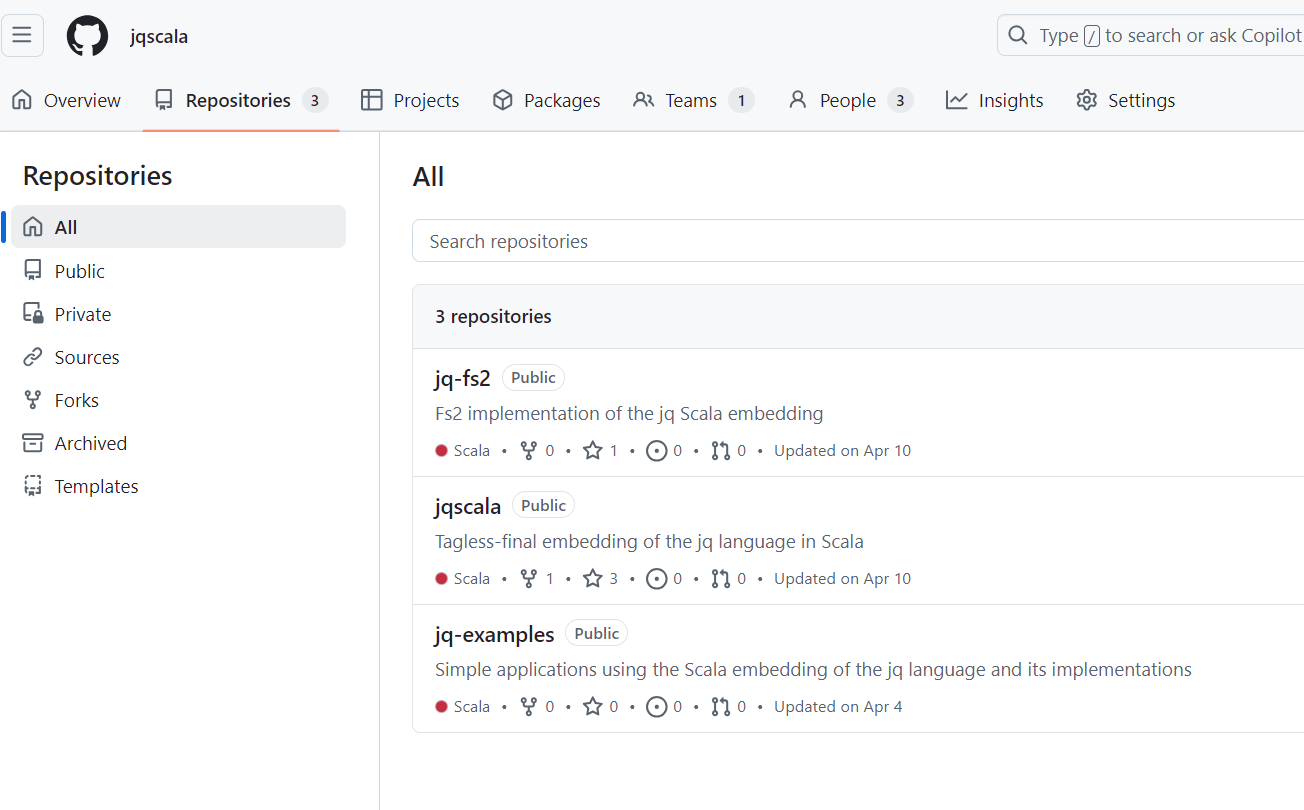

### Conclusion

* _Learn how to abstract over specific semantics using type classes, and understand the advantages and disadvantages of this approach._
    * Advantages refer to the potential for standardization of the language, reuse of the syntactic sugar and built-in library, as well as testing catalogues, etc.
    * For the disadvantages, there is a new module, the type class, which introduces more complexity in the code base.
    <br/><br/>
    
* _Understand the importance of the *standard semantics* of the language._
    * The standard semantics provides the most simple implementation to understand the meaning of the language.
<br/><br/>
* _Gain the ability to implement generic programs using both ad-hoc polymorphic methods and functions._

    * This ability might not be needed at all, and be aware that it introduces further technical complexities.
<br/><br/>

# References

* [Typed Tagless Final Interpreters](https://okmij.org/ftp/tagless-final/index.html#course-oxford), Oleg Kiselyov
* [Tagles final is not MTL](https://github.com/hablapps/tagless-final-tutorial), Habla Computing
* Scala 3: type classes: https://docs.scala-lang.org/scala3/reference/contextual/type-classes.html
* Church encoding: https://okmij.org/ftp/tagless-final/course/Boehm-Berarducci.html